In [1]:
using Plots 
using LinearAlgebra 
using Parameters 
using Statistics

In [2]:
module My

using Parameters 

@with_kw struct PhysicalParam @deftype Float64
    Nspin::Int64 = 10 # number of spins for each direction
    Nthermal::Int64 = 100
    Nsweep::Int64 = 1000
    J = 1.0 # coupling constant between nearest-neighbor pair
    H = 0.0 # magnetic field
    β = 1.0 # inverse temperature
end

end # module 

Main.My

In [3]:
param = My.PhysicalParam()

Main.My.PhysicalParam
  Nspin: Int64 10
  Nthermal: Int64 100
  Nsweep: Int64 1000
  J: Float64 1.0
  H: Float64 0.0
  β: Float64 1.0


In [24]:
function initial_spin(param; random=false)
    @unpack Nspin = param
    
    spins = ones(Int64, Nspin, Nspin)
    
    if random
        for iy in 1:Nspin
            for ix in 1:Nspin 
                if rand() < 0.5 
                    spins[ix, iy] = +1
                else
                    spins[ix, iy] = -1
                end
            end
        end
    end
    
    return spins
end

function test_initial_spin(param)
    @unpack Nspin = param 
    
    spins = initial_spin(param; random=true)
    return spins
end

test_initial_spin (generic function with 1 method)

In [25]:
test_initial_spin(param)

10×10 Matrix{Int64}:
 -1   1   1   1  -1   1   1  -1   1  -1
  1   1  -1   1   1  -1  -1   1  -1   1
 -1   1   1   1   1   1  -1  -1  -1   1
  1   1   1  -1   1   1   1   1   1   1
 -1   1  -1  -1  -1   1  -1   1   1  -1
 -1   1   1   1  -1   1  -1  -1   1   1
  1   1  -1  -1  -1   1  -1   1   1  -1
 -1   1  -1  -1  -1  -1  -1   1  -1  -1
  1  -1  -1  -1   1  -1   1  -1   1   1
 -1   1  -1  -1   1   1  -1  -1  -1  -1

### Hamiltonian

In [6]:
function Hamiltonian(param, spins)
    @unpack Nspin, J, H, β = param
    
    E = 0.0
    for iy in 1:Nspin
        for ix in 1:Nspin
            E += -H*spins[ix, iy]
            
            E += -J*spins[ix, iy]*spins[ifelse(ix+1<=Nspin, ix+1, 1), iy]
            
            E += -J*spins[ix, iy]*spins[ix, ifelse(iy+1<=Nspin, iy+1, 1)]
        end
    end
    
    return E
end

function test_Hamiltonian(param)
    @unpack Nspin = param 
    spins = ones(Int64, Nspin, Nspin)
    @time E = Hamiltonian(param, spins)
end

test_Hamiltonian (generic function with 1 method)

In [7]:
test_Hamiltonian(param)

  0.000001 seconds


-200.0

### Heat Bath Method

In [35]:
function update!(spins, param)
    @unpack Nspin, J, H, β = param 
    
    for iy in 1:Nspin
        for ix in 1:Nspin 
            
            Heff  = H 
            Heff += J*spins[ifelse(ix+1<=Nspin, ix+1, 1), iy] 
            Heff += J*spins[ix, ifelse(iy+1<=Nspin, iy+1, 1)]
            Heff += J*spins[ifelse(ix-1>=1, ix-1, Nspin), iy]
            Heff += J*spins[ix, ifelse(iy-1>=1, iy-1, Nspin)]
            
            if rand() < exp(β*Heff)/(exp(β*Heff) + exp(-β*Heff))
                spins[ix, iy] = +1
            else
                spins[ix, iy] = -1
            end
            
        end
    end
end

function test_thermalization(param)
    @unpack Nspin, Nthermal, Nsweep = param 
    
    # ordered start
    spins_ordered = initial_spin(param)
    
    Es_ordered         = zeros(Float64, Nthermal)
    Es_average_ordered = zeros(Float64, Nthermal)
    
    for isweep in 1:Nthermal
        update!(spins_ordered, param)
        Es_ordered[isweep] = Hamiltonian(param, spins_ordered)
        if isweep === 1
            Es_average_ordered[isweep] = Es_ordered[isweep]
        else
            Es_average_ordered[isweep] = Es_average_ordered[isweep-1]*(isweep-1) + Es_ordered[isweep]
            Es_average_ordered[isweep] /= isweep
        end
    end
    
    # ordered start
    spins_random = initial_spin(param; random=true)
    
    Es_random         = zeros(Float64, Nthermal)
    Es_average_random = zeros(Float64, Nthermal)
    
    for isweep in 1:Nthermal
        update!(spins_random, param)
        Es_random[isweep] = Hamiltonian(param, spins_random)
        if isweep === 1
            Es_average_random[isweep] = Es_random[isweep]
        else
            Es_average_random[isweep] = Es_average_random[isweep-1]*(isweep-1) + Es_random[isweep]
            Es_average_random[isweep] /= isweep
        end
    end
    
    p = plot()
    plot!(p, Es_average_ordered; label="ordered start")
    plot!(p, Es_average_random; label="random start")
end

test_thermalization (generic function with 1 method)

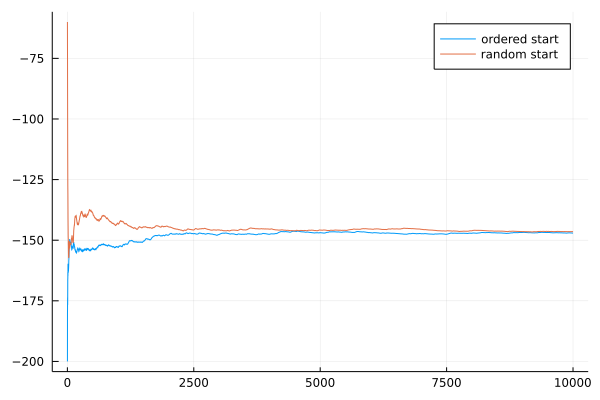

In [66]:
param = My.PhysicalParam(β=0.44, Nthermal=10000)
test_thermalization(param)

In [70]:
function do_Heat_Bath(param; random=false)
    @unpack β, Nspin, Nthermal, Nsweep = param 
    
    spins = initial_spin(param; random=random)
    
    for isweep in 1:Nthermal
        update!(spins, param)
    end
    
    Es = zeros(Float64, Nsweep)
    Ms = zeros(Float64, Nsweep)
    
    for isweep in 1:Nsweep 
        update!(spins, param)
        Es[isweep] = Hamiltonian(param, spins)/Nspin^2
        Ms[isweep] = mean(spins)
    end 
    
    E = mean(Es)
    C = β*β*var(Es)
    
    M = mean(Ms)
    χ = β*var(Ms)
    
    return E, C, M, χ
end

do_Heat_Bath (generic function with 1 method)

In [80]:
param = My.PhysicalParam(Nthermal=10000, Nsweep=10000, Nspin=10)

βs = 10 .^ range(-1, 1, length=100)
Es = zeros(Float64, length(βs))
Cs = zeros(Float64, length(βs))
Ms = zeros(Float64, length(βs))
χs = zeros(Float64, length(βs))

for iβ in 1:length(βs)
    param = My.PhysicalParam(param, β=βs[iβ])
    @time E, C, M, χ = do_Heat_Bath(param; random=false)
    Es[iβ] = E
    Cs[iβ] = C
    Ms[iβ] = ifelse(M>0, M, -M)
    χs[iβ] = χ
end

  0.098988 seconds (14 allocations: 157.516 KiB)
  0.095174 seconds (14 allocations: 157.516 KiB)
  0.117104 seconds (14 allocations: 157.516 KiB)
  0.103000 seconds (14 allocations: 157.516 KiB)
  0.099854 seconds (14 allocations: 157.516 KiB)
  0.100708 seconds (14 allocations: 157.516 KiB)
  0.099156 seconds (14 allocations: 157.516 KiB)
  0.095213 seconds (14 allocations: 157.516 KiB)
  0.100371 seconds (14 allocations: 157.516 KiB)
  0.101711 seconds (14 allocations: 157.516 KiB)
  0.101462 seconds (14 allocations: 157.516 KiB)
  0.105401 seconds (14 allocations: 157.516 KiB)
  0.103649 seconds (14 allocations: 157.516 KiB)
  0.105818 seconds (14 allocations: 157.516 KiB)
  0.100228 seconds (14 allocations: 157.516 KiB)
  0.103713 seconds (14 allocations: 157.516 KiB)
  0.108939 seconds (14 allocations: 157.516 KiB)
  0.115573 seconds (14 allocations: 157.516 KiB)
  0.107179 seconds (14 allocations: 157.516 KiB)
  0.101555 seconds (14 allocations: 157.516 KiB)
  0.105390 seconds (

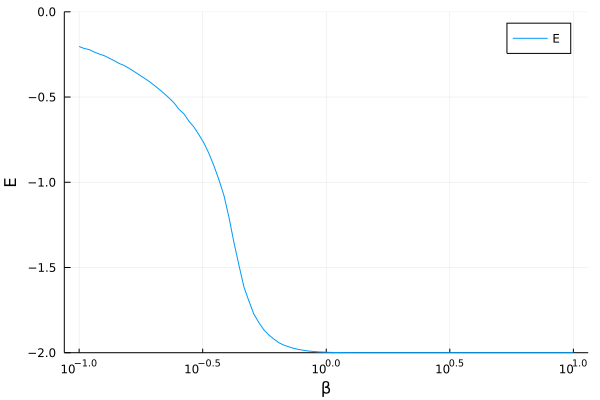

In [81]:
p = plot(xlabel="β", ylabel="E", xaxis=:log, ylim=(-2,0))
plot!(p, βs, Es; label="E")

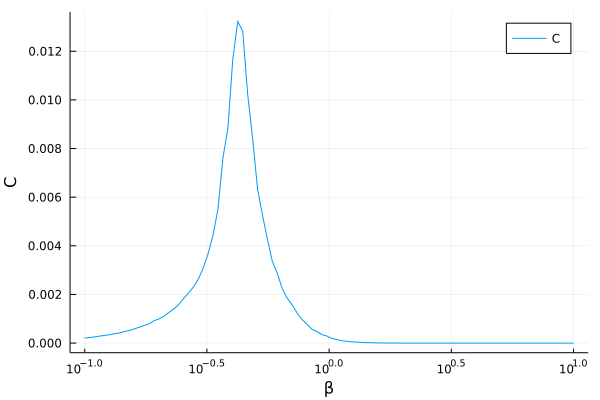

In [82]:
p = plot(xlabel="β", ylabel="C", xaxis=:log)
plot!(p, βs, Cs; label="C")

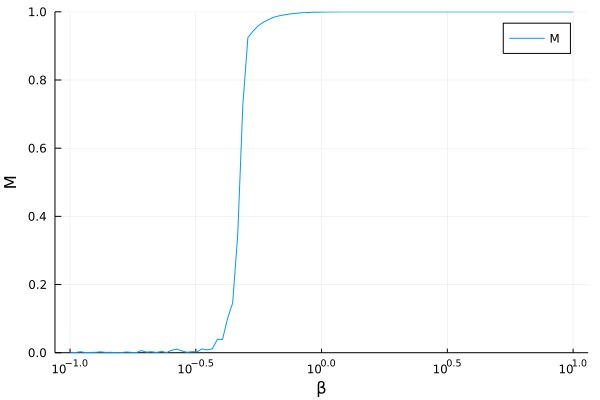

In [83]:
p = plot(xlabel="β", ylabel="M", xaxis=:log, ylim=(0,1))
plot!(p, βs, Ms; label="M")

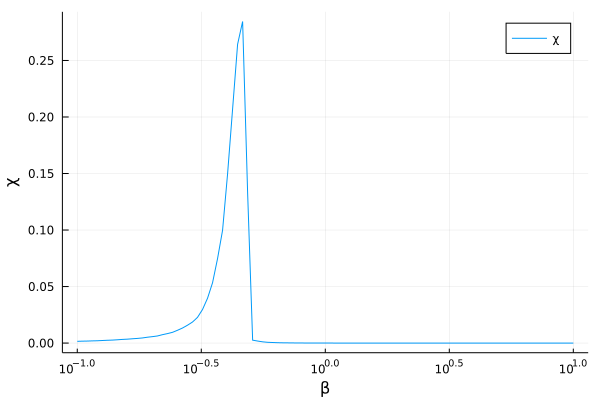

In [84]:
p = plot(xlabel="β", ylabel="χ", xaxis=:log)
plot!(p, βs, χs; label="χ")